In [1]:
import numpy as np
import scipy.signal
from datetime import datetime
from fur.one_data_set_analyzer import analyze_one_dataset
from scipy.optimize import minimize
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
import lattice.lattice as lattice
from lattice.summary_in_undulator import get_summary_in_undulator
shift_03_10_2020 = path_assistant.PathAssistant('shift_03_10_2020',      
    ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])
waveforms_dir = shift_03_10_2020.get_waveforms_dir()
results_dir = shift_03_10_2020.get_results_dir()
fluctuations_df = shift_03_10_2020.get_fluctuations_df("res_df_nd_filters_data_plus_acnet_03_10_2020.csv")
lattice_file = shift_03_10_2020.get_6dsim_dir().fi("IOTA_1NL_100MeV_v8.6.1.3.6ds_data.txt")
t1 = datetime(2020, 3, 10, 11, 32, 0)
t2 = datetime(2020, 3, 10, 12, 58, 0)

In [2]:
wf_paths = [p for p in shift_03_10_2020.get_waveform_paths() if
                (t1 < shift_03_10_2020.get_datetime(os.path.basename(p)) < t2)]
fp = wf_paths[0]

In [3]:
from config import get_from_config
dt = get_from_config("dt")
Rf = get_from_config("Rf")
e = get_from_config("e")

In [4]:
ch1, ch2 = read_waveform(fp)
output = {}
period = get_period(ch2, output_dic=output)
trig_times = output["trig_times"]
int_period = int(period)

In [5]:
start_to_trigger = 200
start_of_first_full_period = int(trig_times[0]-start_to_trigger)
end_of_last_full_period = int(trig_times[-1]-start_to_trigger)

In [6]:
ch_df = pd.DataFrame({
    "ch1": ch1[start_of_first_full_period:end_of_last_full_period],
    "ch2": ch2[start_of_first_full_period:end_of_last_full_period]})
ch_df["period_number"] = (ch_df.index.to_numpy()/period).astype(int)

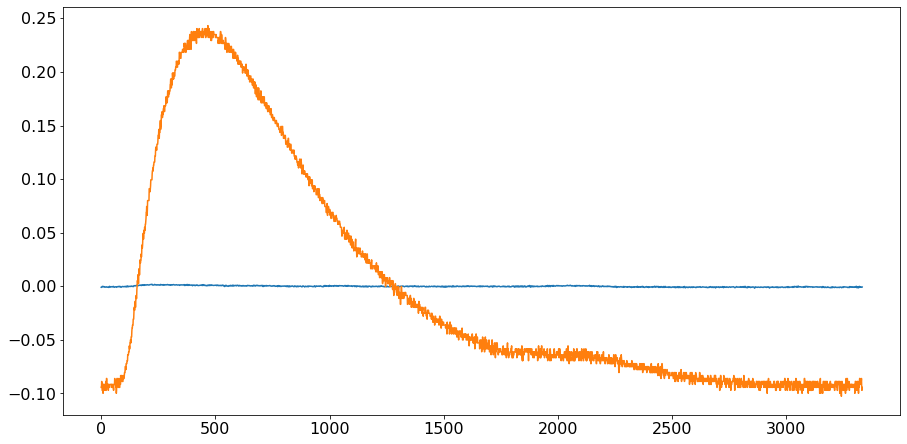

In [7]:
plt.plot(ch_df.loc[:int_period,"ch1"])
plt.plot(ch_df.loc[:int_period,"ch2"])

In [8]:
integration_end_ns = 50
integration_end = int(integration_end_ns/dt)

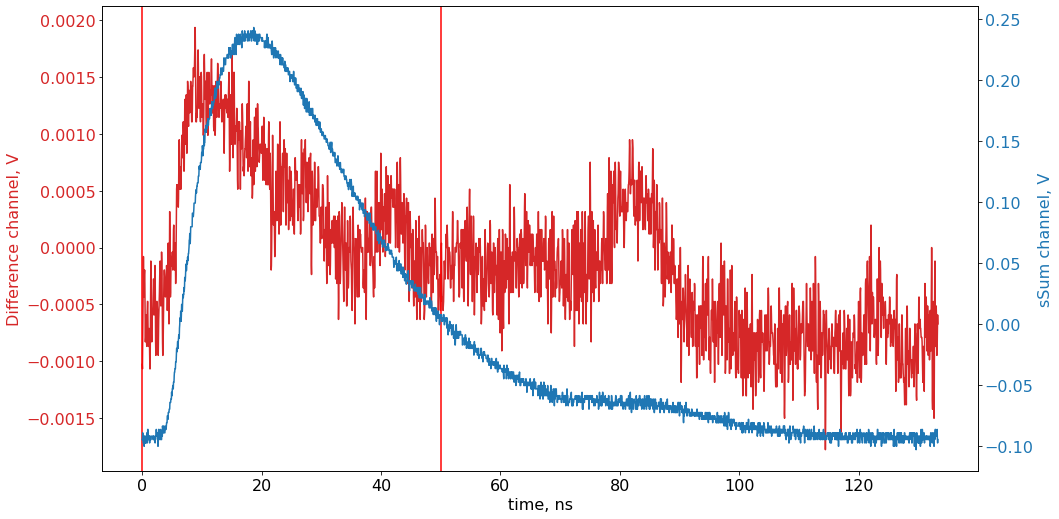

In [9]:
time_arr = dt*np.arange(int_period+1)
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time, ns')
ax1.set_ylabel('Difference channel, V', color=color)
ax1.plot(time_arr, ch_df.loc[:int_period,"ch1"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sSum channel, V', color=color)  # we already handled the x-label with ax1
ax2.plot(time_arr, ch_df.loc[:int_period,"ch2"], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.axvline(0, color='red')
ax1.axvline(integration_end_ns, color='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [10]:
ch1_int = ch_df.groupby(["period_number"])['ch1'].apply(np.asarray).apply(lambda ch1: np.sum(ch1[:integration_end])*dt).to_list()

In [11]:
ch2_periods = 10
ch2_int = ch_df[ch_df["period_number"]<ch2_periods].groupby(["period_number"])['ch2'].apply(np.asarray).apply(lambda ch2: np.sum(ch2[:integration_end])*dt).values

In [12]:
res = [np.mean(ch2_int)]+ch1_int

In [13]:
from fur.fluctuations_individual_periods import analyze_one_file

In [14]:
res = analyze_one_file(fp)

In [15]:
res[0]

135.40822143554686

In [16]:
res[1:10]

[0.4852173924446106,
 0.4579051733016968,
 0.624505877494812,
 0.5398814082145691,
 0.373517781496048,
 0.4449011981487274,
 0.7271540760993958,
 0.6954150199890137,
 0.274664044380188]